In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

## Load Dataset

In [2]:
X_train = np.loadtxt('TinyMNIST/trainData.csv', dtype=np.float32, delimiter=',')
y_train = np.loadtxt('TinyMNIST/trainLabels.csv', dtype=np.int32, delimiter=',')

X_test = np.loadtxt('TinyMNIST/testData.csv', dtype=np.float32, delimiter=',')
y_test = np.loadtxt('TinyMNIST/testLabels.csv', dtype=np.int32, delimiter=',')

print(X_train.shape)
print(X_test.shape)

(5000, 196)
(2500, 196)


## Classification without Dimentionality Reduction

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [4]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

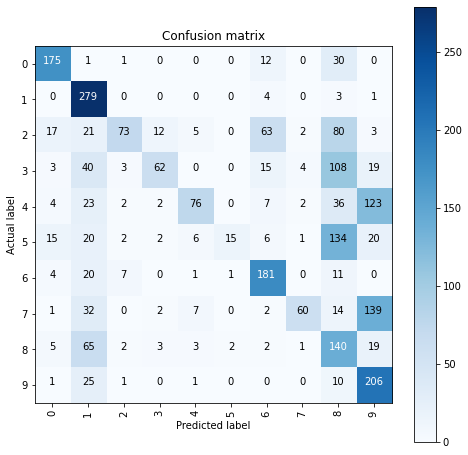

In [5]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, range(10))

In [6]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_test, y_predict)
print('Accuracy: %0.3f' % total_acc)

labels = list(set(y_test))
ccr = [cm[i, i] / cm[i, :].sum() for i in range(len(labels))]
for i, l in enumerate(labels):
    print('CCR-%s: %0.3f' % (l, ccr[i]))

Accuracy: 0.507
CCR-0: 0.799
CCR-1: 0.972
CCR-2: 0.264
CCR-3: 0.244
CCR-4: 0.276
CCR-5: 0.068
CCR-6: 0.804
CCR-7: 0.233
CCR-8: 0.579
CCR-9: 0.844


## Feature Filtering

In [7]:
from sklearn.feature_selection import VarianceThreshold

# Feature Filtering
tr_samples_size, _ = X_train.shape
all_data = np.vstack((X_train, X_test))
sel = VarianceThreshold(threshold=0.90*(1-0.90))
all_data = sel.fit_transform(all_data)
X_train_filtered = all_data[:tr_samples_size]
X_test_filtered = all_data[tr_samples_size:]

print(X_train_filtered.shape)
print(X_test_filtered.shape)

(5000, 62)
(2500, 62)


## Feature Selection from Scratch

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

def objective_function(feature_subset):
    clf = GaussianNB(var_smoothing=1e-5)
    cv = cross_val_score(clf, X_train_filtered[:, feature_subset], y_train, cv=5, scoring='accuracy')
    return cv.mean()

# forward selection
def feature_selection(X_train):
    feature_set = list(range(X_train.shape[1]))
    feature_subset = []
    accs = []
    for count in range(X_train.shape[1]):
        objs = [objective_function(feature_subset+[feature]) for feature in feature_set]
        idx = np.argmax(objs)
        accs.append(objs[idx])
        feature_subset.append(feature_set[idx])
        feature_set.remove(feature_set[idx])
        
    return feature_subset, accs

In [9]:
# might take time :D (less than 2 min)
feature_subset, accs = feature_selection(X_train_filtered)

## Optimal Feature Subset

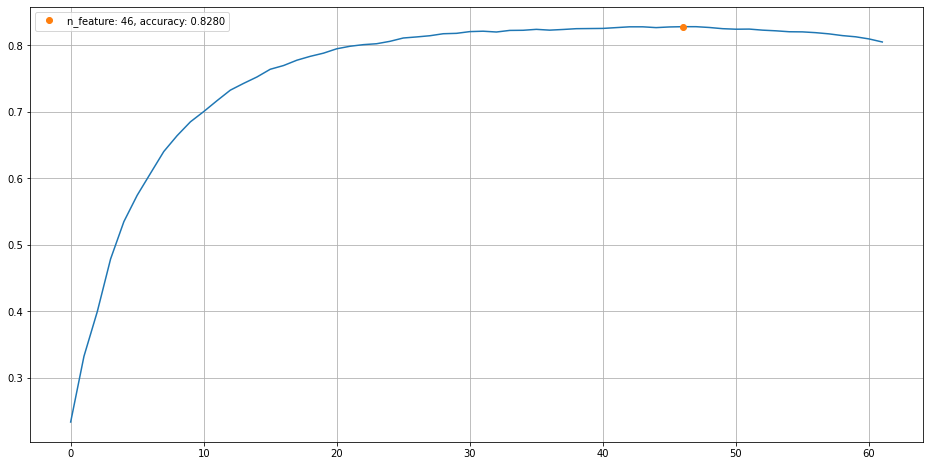

In [10]:
plt.figure(figsize=(16, 8))
plt.plot(accs)

m_idx = np.argmax(accs)
plt.plot(m_idx, accs[m_idx], 'o', label='n_feature: %d, accuracy: %0.4f' % (m_idx, accs[m_idx]))

plt.legend()
plt.grid()
plt.show()

# optimal feature subset
ofs = feature_subset[:m_idx]

## Classification with Dimentionality Reduction

In [11]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB(var_smoothing=1e-5)
clf.fit(X_train_filtered[:, ofs], y_train)

y_predict = clf.predict(X_test_filtered[:, ofs])

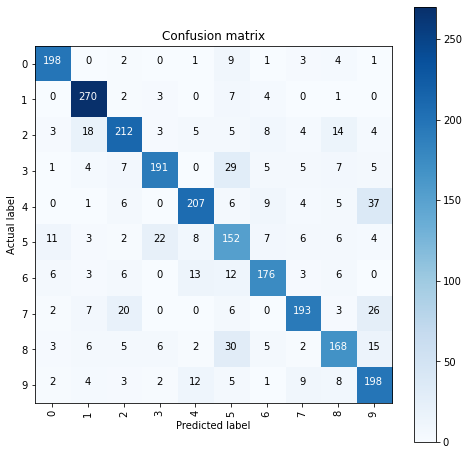

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, range(10))

In [13]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_test, y_predict)
print('Accuracy: %0.3f' % total_acc)

Accuracy: 0.786
